# House Prices: Advanced Regression Techniques

This notebook assesses a housing dataset for Ames, Iowa providing the opportunity to use regression techniques for house prices with 79 explanatory variables. These variables include many attributes about the house including square footage, amenities, exterior conditions, neighborhood, year built/sold, rooms/bathrooms amongst many others.  
  
My analysis follows:  
  
1. Data Loading  
2. Data Cleaning 
3. Data Exploration
4. Feature Engineering  
5. Regression Model & Model Tuning
6. Final Model & Discussion
  
The data set is available <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview">here</a>.

<font size="3"> <b>  1. Data Loading </b></font>

In [49]:
#Load the packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import hvplot.pandas
warnings.filterwarnings('ignore')
%matplotlib inline

ModuleNotFoundError: No module named 'hvplot'

In [13]:
#Load both the training and testing datasets so that they can be cleaned together. These will be split again later.
#Create a new column so we can identify these datasets again later
df_train = pd.read_csv(r'C:\Users\perry\Desktop\house-prices-advanced-regression-techniques\train.csv')
df_train['Train/Test'] = 'Train'
df_test = pd.read_csv(r'C:\Users\perry\Desktop\house-prices-advanced-regression-techniques\test.csv')
df_test['Train/Test'] = 'Test'

In [14]:
#combine the datasets together
df_combined = df_train.append(df_test)

In [15]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

<font size="3"> <b>  2. Data Cleaning </b></font>

In [16]:
#Convert some of the key variables are coded properly. Recode them as either categories or integers.
df_combined['MSSubClass'] = df_combined['MSSubClass'].astype('object')
# df_combined['MoSold'] = df_combined['MoSold'].astype('object')
# df_combined['YrSold'] = df_combined['YrSold'].astype('object')
# # df_combined['GarageYrBlt'] = df_combined['GarageYrBlt'].astype('int')

In [17]:
#Identify any columns with missing values
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = (df_combined.isnull().sum()/df_combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471
GarageQual,159,0.054471


<b> Dealing with missing values in Categorical Data with Similar Probabilities: Delete method </b>
- Missing values with same probabilities are deleted. Reference: https://medium.com/coinmonks/dealing-with-missing-data-using-r-3ae428da2d17
- PoolQC, MiscFeature, Alley, and Fence don't seem like important features people would look at when buying a house. Therefore, we will ignore missing values for these variables
- All the "Garage" features have the same % of missing variables. Since most important variable is "GarageCars", we will ignore/delete all the Garage columns.
- Similarly, since all "Basement" features have similar % of missing variables, and we only care about TotalBsmtSF, we will ignore/delete all Basement columns
- Masonry Veneer are considered non-essential 

In [18]:
#Delete columns with missing data where probabilities are the same
df_combined = df_combined.drop(columns = ['PoolQC','MiscFeature','Alley','Fence','GarageFinish','GarageYrBlt','GarageQual','GarageCond','GarageType','BsmtCond','BsmtExposure','BsmtQual','MSZoning','BsmtFinType2','BsmtFinType1','MasVnrType','MasVnrArea','FireplaceQu','LotFrontage'])
df_combined = df_combined.drop(df_combined.loc[df_train['Electrical'].isnull()].index)

<b> Dealing with missing values in Discrete Data and Categorical Data with non-similar probabilities </b>

- For all Discrete Values, missing data was imputed using the mean
- For all Categorical Values, missing data was imputed using the mode

In [19]:
#Impute Discrete Data with Mean
df_combined['TotalBsmtSF']=df_combined['TotalBsmtSF'].replace(0,df_combined['TotalBsmtSF'].mean())
df_combined['TotalBsmtSF']=df_combined['TotalBsmtSF'].replace(np.nan,df_combined['TotalBsmtSF'].mean())

df_combined['BsmtFullBath']=df_combined['BsmtFullBath'].replace(0,df_combined['BsmtFullBath'].mean())
df_combined['BsmtFullBath']=df_combined['BsmtFullBath'].replace(np.nan,df_combined['BsmtFullBath'].mean())

df_combined['BsmtHalfBath']=df_combined['BsmtHalfBath'].replace(0,df_combined['BsmtHalfBath'].mean())
df_combined['BsmtHalfBath']=df_combined['BsmtHalfBath'].replace(np.nan,df_combined['BsmtHalfBath'].mean())

df_combined['GarageCars']=df_combined['GarageCars'].replace(0,df_combined['GarageCars'].mean())
df_combined['GarageCars']=df_combined['GarageCars'].replace(np.nan,df_combined['GarageCars'].mean())

#Impute Categorical Data with Mode
mode = df_combined['SaleType'].mode().iat[0]
df_combined['SaleType'].fillna(mode,inplace=True)


In [21]:
#Delete any other columns with missing data as we have similar variables with explanatory power
df_combined = df_combined.drop((missing_data[missing_data['Total'] == 1]).index,1)
df_combined = df_combined.drop((missing_data[missing_data['Total'] == 2]).index,1)

In [22]:
#Look at remaining missing values after the dropped columns
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = (df_combined.isnull().sum()/df_combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
SalePrice,1458,0.499829
Train/Test,0,0.000000
OverallQual,0,0.000000
HeatingQC,0,0.000000
Heating,0,0.000000
TotalBsmtSF,0,0.000000
Foundation,0,0.000000
ExterCond,0,0.000000
ExterQual,0,0.000000
RoofMatl,0,0.000000


- Only SalesPrice remains with missing data from Test datset, which is the target variable in the testing dataset we are trying to solve.
- All other 0 missing data variables have been addressed.
- Both Training and Testing sets have been cleaned

<font size="3"> <b>  3. Features Engineering </b></font>

After reviewing the dataset, I added a few more columns which could help simplify the dataset and add more explanatory power. 

These include:
1. <b> Total Square Feet </b>: Sum of GrLivArea + TotalBsmtSF
2. <b> Remodeled: If YearRemodAdd </b> = YearBuilt, then the unit has not been remodeled
3. <b> Total Porch Square Feet </b>: Sum of all Porches (OpenPorchSF + EnclosedPorch + 3SsnPorch)
4. <b> Porch Included </b>: If Total Porch Square Feet > 0, then there's a porch
5. <b> Bathrooms </b>: Sum of all types of bathrooms 

In [23]:
df_combined['Total Square Feet'] = df_combined['GrLivArea'] + df_combined['TotalBsmtSF']
df_combined['Remodeled'] = np.where(df_combined['YearRemodAdd'] == df_combined['YearBuilt'],'0','1')
df_combined['Total Porch Square Feet'] = df_combined['OpenPorchSF'] + df_combined['EnclosedPorch'] + df_combined['3SsnPorch']
df_combined['Porch Included'] = np.where(df_combined['Total Porch Square Feet'] > 0,'1','0')
df_combined['Bathrooms'] = df_combined['BsmtFullBath'] + df_combined['BsmtHalfBath'] + df_combined['FullBath'] + df_combined['HalfBath']

In [24]:
#Filter for the Training Dataset only
df_train = df_combined[df_combined['Train/Test'] == 'Train']

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       1459 non-null   int64  
 1   MSSubClass               1459 non-null   object 
 2   LotArea                  1459 non-null   int64  
 3   Street                   1459 non-null   object 
 4   LotShape                 1459 non-null   object 
 5   LandContour              1459 non-null   object 
 6   LotConfig                1459 non-null   object 
 7   LandSlope                1459 non-null   object 
 8   Neighborhood             1459 non-null   object 
 9   Condition1               1459 non-null   object 
 10  Condition2               1459 non-null   object 
 11  BldgType                 1459 non-null   object 
 12  HouseStyle               1459 non-null   object 
 13  OverallQual              1459 non-null   int64  
 14  OverallCond             

<b> Exploring the Datasets Relationship with Sales Price </b>

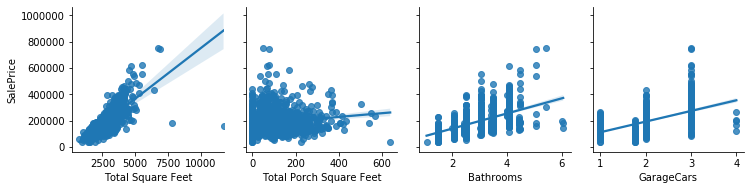

In [26]:
# multiple scatterplots in Seaborn
feature_cols = ['Total Square Feet','Total Porch Square Feet','Bathrooms','GarageCars']
sns.pairplot(df_train, x_vars=feature_cols, y_vars='SalePrice', kind='reg');

- <b> Total Square Feet </b> There is a strong linear relationship between Total Square Feet and SalesPrice
- <b> Total Porch Square Feet </b> The relationship between porch square feet and sales price is more flat
- <b> Bathrooms </b> There is a linear relationship between # of bathrooms and sales price
- <b> GarageCars </b> There is a linear relationship between # of Parking Garage and sales prices

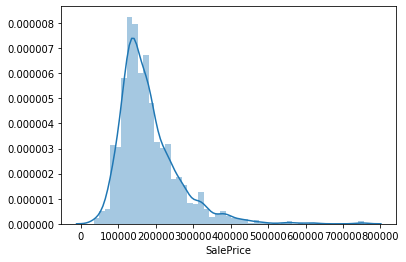

In [27]:
sns.distplot(df_train['SalePrice'])

- The data is right skewed. Mean > Median > Mode
- Most sales are in the 200k range, and number of sales exponentially decreases with increase in salesprice over 200k
- We might consider using a logistic regression instead of a linear one

<b> Correlation and Relationships </b>

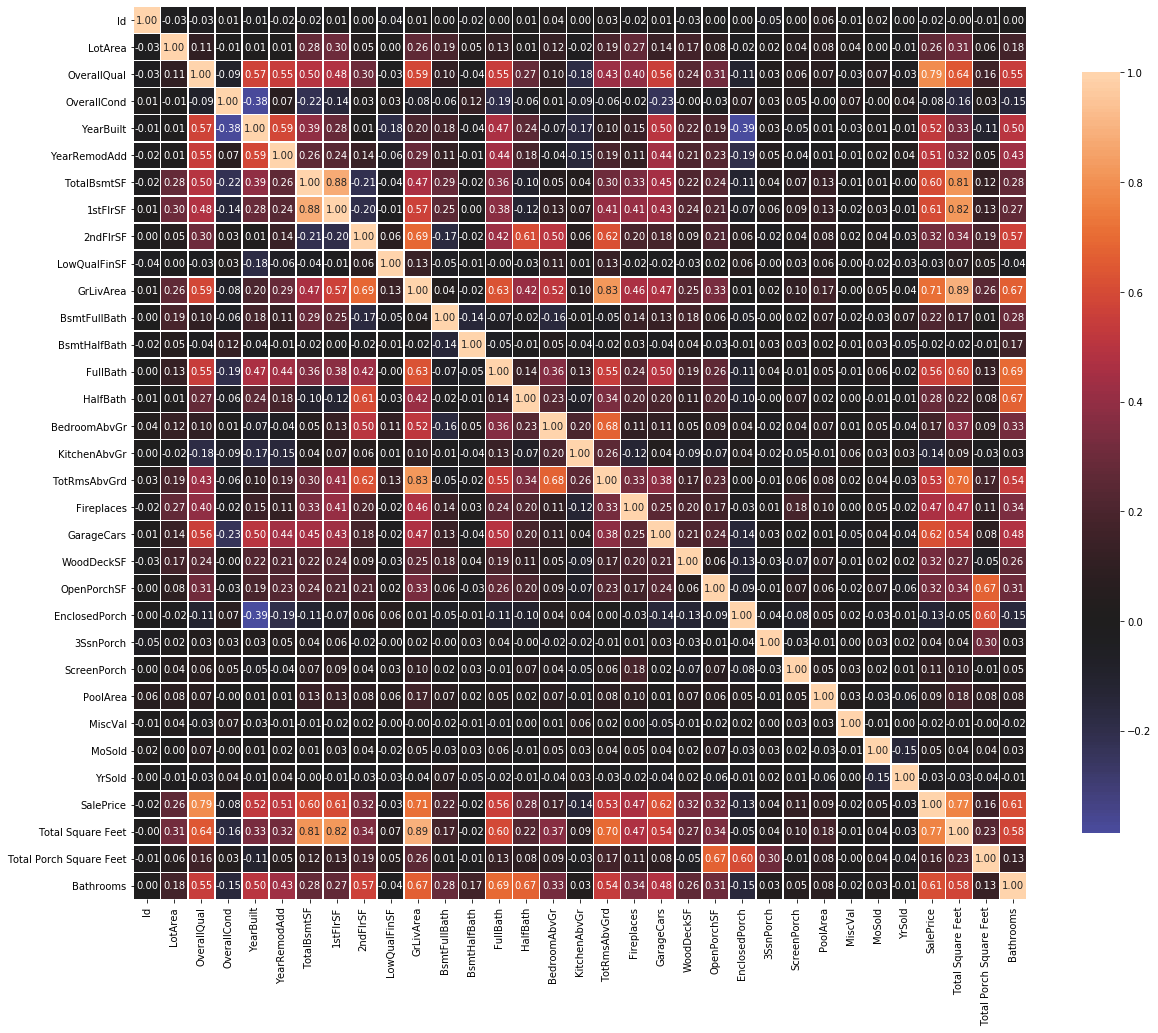

In [28]:
## Code modified from: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
def correlation_heatmap(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .7})
    plt.show();
    
correlation_heatmap(df_train)

- Overall Quality, Total Square Feet are highly correlated with sales Price >0.70
- YearBuilt, Bathrooms, GarageCars, Year Remodeled all have some correlation with SoldPrice to varying degrees (~0.5-0.6)
- MontSold and YearSold have no correlation with SalesPrice

- Total Square Feet includes GrLivArea, 1stFlrSF, and Total BsmtSF
- Bathrooms include FullBath
- We should remove these variables from the dataset

In [29]:
#Remove these columns from the dataset as they are already included in other variables
df_train = df_train.drop(columns = ['GrLivArea','1stFlrSF','TotalBsmtSF','FullBath'])

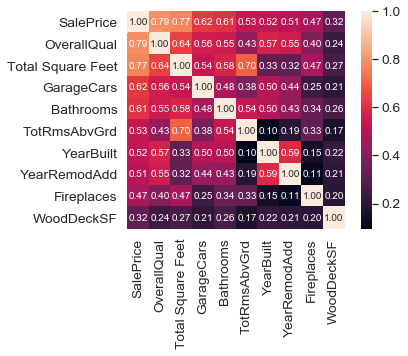

In [30]:
#saleprice correlation matrix for top 10 correlated variables
k = 10 #number of variables for heatmap
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- Fireplace and Wooddeck are two additional features we haven't considered before, but does not seem they have high correlations to SalePrice

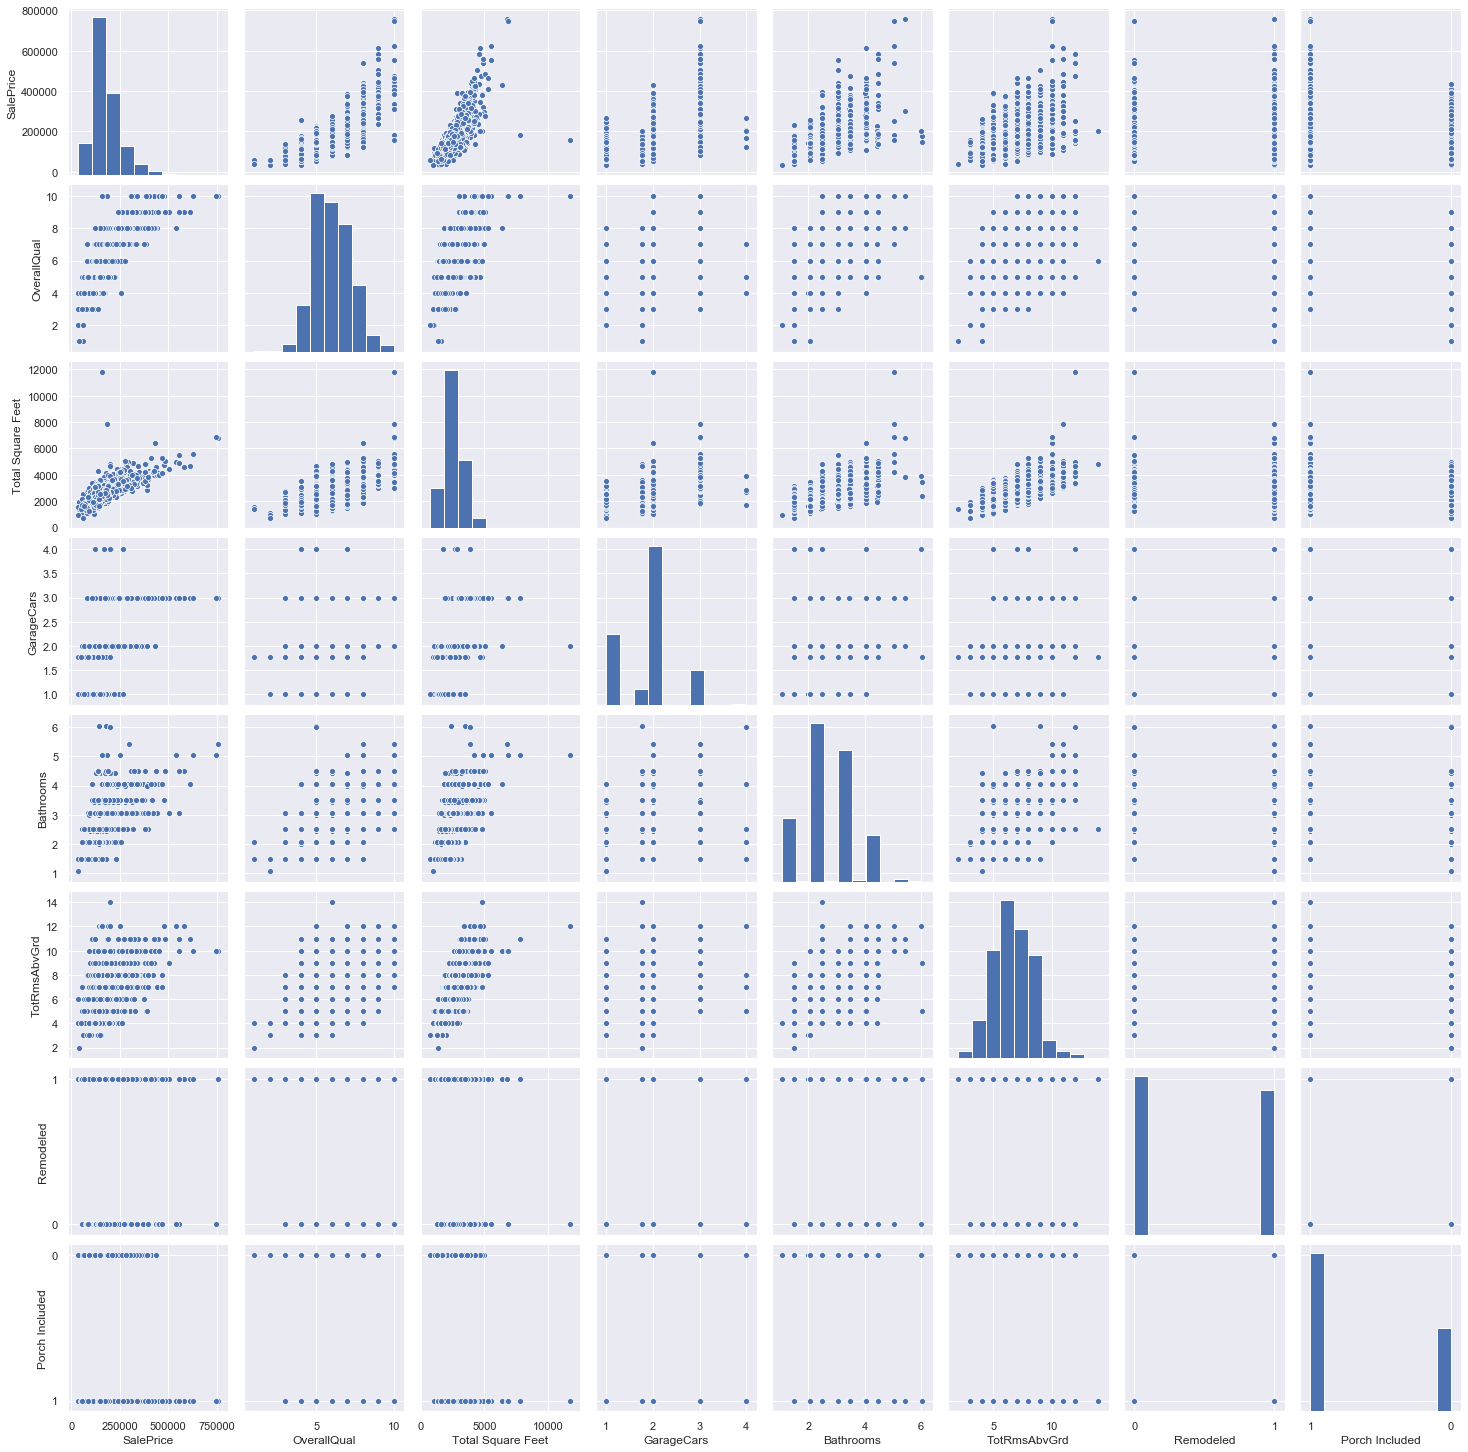

In [31]:
#Scatterplot of Correlated Variables
sns.set()
cols = ['SalePrice','OverallQual','Total Square Feet','GarageCars','Bathrooms','TotRmsAbvGrd','Remodeled','Porch Included']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

- SalesPrice exhibit mostly positive linear relationship with most remaining variables.
- Against YearBuilt, seems like newer buildings have exponentially higher selling price than older buildings

<b> Outliers </b>

In [32]:
#Remove outliers from Total Square Feet
df_train = df_train.drop(df_train[df_train['Total Square Feet'] > 6000].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


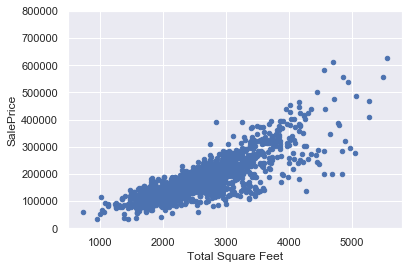

In [36]:
#bivariate analysis SalePrice and Total Square Feet
var = 'Total Square Feet'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

- Outliers over 6000 square feet have been removed from the dataset

<font size="3"> <b>  4. Regression Model & Model Tuning </b></font>

In [37]:
# Import, instantiate, fit.
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [53]:
#Create a list of the features
feature_cols = ['OverallQual','Total Square Feet','GarageCars','Bathrooms','TotRmsAbvGrd','Remodeled','Porch Included']
df_train[feature_cols]

,OverallQual,Total Square Feet,GarageCars,Bathrooms,TotRmsAbvGrd,Remodeled,Porch Included
0,7,2566.0,2.0,4.061407,8,0,1
1,6,2524.0,2.0,3.429846,6,0,0
2,7,2706.0,2.0,4.061407,6,1,1
3,7,2473.0,3.0,2.061407,7,1,1
4,8,3343.0,3.0,4.061407,9,0,1
...,...,...,...,...,...,...,...
1455,6,2600.0,2.0,3.491252,7,1,1
1456,6,3615.0,2.0,3.061407,7,1,0
1457,7,3492.0,1.0,2.491252,9,1,1
1458,5,2156.0,1.0,2.061407,5,1,1


In [54]:
#Create X and y
X = df_train[feature_cols]
y = df_train.SalePrice

#Instantiate and fit
linreg = LinearRegression()
linreg.fit(X,y)

#Print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

-120840.03292223514
[22512.45429461    50.38483665 15238.8428727   9524.75603944
 -3496.09112918  5903.57695043 -1218.65631935]


In [40]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('OverallQual', 22512.454294614115),
 ('Total Square Feet', 50.38483664816443),
 ('GarageCars', 15238.842872699153),
 ('Bathrooms', 9524.75603944001),
 ('TotRmsAbvGrd', -3496.091129182459),
 ('Remodeled', 5903.576950432713),
 ('Porch Included', -1218.6563193513673)]

Interpreting the Intercept:
- The model exhibits a negative intercept, which could imply that the model is overestimating the y-values. We can try to use StandardScaler to scale the dataset.


Interpreting the Coefficients:
    
- Holding all other features fixed, a 1-unit increase in Overall Quality is associated with a Sale Price increase of 22,512
- Holding all other features fixed, a 1-unit increase in Total Square Feet is associated with a Sale Price increase of 50
- Holding all other features fixed, a 1-unit increase in GarageCars is associated with a Sale Price increase of 15,238
- Holding all other features fixed, a 1-unit increase in Bathrooms is associated with a Sale Price increase of 9,524
- Holding all other features fixed, a 1-unit increase in Total Rooms is associated with a Sale Price decrease of 3,596
- Holding all other features fixed, a 1-unit increase in Remodelled homes is associated with a Sale Price increase of 5,903
- Holding all other features fixed, a 1-unit increase in Porches is associated with a Sale Price decrease of 1,218

<b> Scaling the dataset using Standard Scaler to adjust for negative intercept </b>

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [56]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [57]:
print(lin_reg.intercept_)

179710.31284403673


In [58]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
OverallQual,31282.172577
Total Square Feet,37946.275500
GarageCars,9068.572256
Bathrooms,6887.509300
TotRmsAbvGrd,-6125.837429
Remodeled,2960.093292
Porch Included,-764.785061


Results are largely the same. 

- While intercept is positive, Rooms and Porches both continue to have a negative impact on price.

<b> Testing for Multicollinearity </b>

                   OverallQual  Total Square Feet  GarageCars  Bathrooms  \
OverallQual           1.000000           0.648227    0.556915   0.538730   
Total Square Feet     0.648227           1.000000    0.565313   0.577636   
GarageCars            0.556915           0.565313    1.000000   0.474924   
Bathrooms             0.538730           0.577636    0.474924   1.000000   
TotRmsAbvGrd          0.414974           0.708202    0.379350   0.530336   

                   TotRmsAbvGrd  
OverallQual            0.414974  
Total Square Feet      0.708202  
GarageCars             0.379350  
Bathrooms              0.530336  
TotRmsAbvGrd           1.000000  
AxesSubplot(0.125,0.125;0.62x0.755)


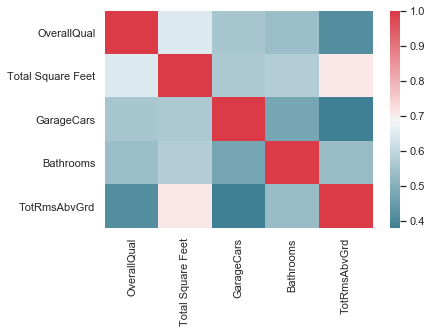

In [182]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = df_train[['OverallQual','Total Square Feet','GarageCars','Bathrooms','TotRmsAbvGrd','Remodeled','Porch Included']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))

- None of the other identified features have significant correlation with one another.

<b> Loss Functions: Comparing Models with Train/Test Split and RMSE </b>

Use Train/TestSplit and Cross-Validation for Feature Selection to see what features to include in the model

In [121]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.SalePrice
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) #helps split data into training and testing
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

def train_test_mae(df, feature_cols):
    X = df[feature_cols]
    y = df.SalePrice
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) #helps split data into training and testing
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return metrics.mean_absolute_error(y_test, y_pred)

def train_test_mse(df, feature_cols):
    X = df[feature_cols]
    y = df.SalePrice
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) #helps split data into training and testing
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return metrics.mean_squared_error(y_test, y_pred)

In [130]:
#Use the backward method of stepwise regression to differentiate variables that are noise vs signals

Feature1 = ['OverallQual','Total Square Feet','GarageCars','Bathrooms','TotRmsAbvGrd','Remodeled','Porch Included']
Feature2 = ['OverallQual','Total Square Feet','GarageCars','Bathrooms','TotRmsAbvGrd','Remodeled']
Feature3 = ['OverallQual','Total Square Feet','GarageCars','Bathrooms','TotRmsAbvGrd']
Feature4 = ['OverallQual','Total Square Feet','GarageCars']
Feature5 = ['OverallQual','Total Square Feet']
Feature6 = ['OverallQual','Total Square Feet','GarageCars','Bathrooms']
Feature7 = ['OverallQual','GarageCars','Bathrooms','TotRmsAbvGrd','Remodeled','Porch Included']
Feature8 = ['OverallQual','Bathrooms','TotRmsAbvGrd','Remodeled','Porch Included']
Feature9 = ['OverallQual','TotRmsAbvGrd','Remodeled','Porch Included']
Feature10 = ['OverallQual','Remodeled','Porch Included']

print('Feature1 - ','RMSE:',train_test_rmse(df_train, Feature1),'| MSE:',train_test_mse(df_train, Feature1),'| MAE:',train_test_mae(df_train,Feature1))
print('Feature2 - ','RMSE:',train_test_rmse(df_train, Feature2),'| MSE:',train_test_mse(df_train, Feature2),'| MAE:',train_test_mae(df_train,Feature2))
print('Feature3 - ','RMSE:',train_test_rmse(df_train, Feature3),'| MSE:',train_test_mse(df_train, Feature3),'| MAE:',train_test_mae(df_train,Feature3))
print('Feature4 - ','RMSE:',train_test_rmse(df_train, Feature4),'| MSE:',train_test_mse(df_train, Feature4),'| MAE:',train_test_mae(df_train,Feature4))
print('Feature5 - ','RMSE:',train_test_rmse(df_train, Feature5),'| MSE:',train_test_mse(df_train, Feature5),'| MAE:',train_test_mae(df_train,Feature5))
print('Feature6 - ','RMSE:',train_test_rmse(df_train, Feature6),'| MSE:',train_test_mse(df_train, Feature6),'| MAE:',train_test_mae(df_train,Feature6))
print('Feature7 - ','RMSE:',train_test_rmse(df_train, Feature7),'| MSE:',train_test_mse(df_train, Feature7),'| MAE:',train_test_mae(df_train,Feature7))
print('Feature8 - ','RMSE:',train_test_rmse(df_train, Feature8),'| MSE:',train_test_mse(df_train, Feature8),'| MAE:',train_test_mae(df_train,Feature8))
print('Feature9 - ','RMSE:',train_test_rmse(df_train, Feature9),'| MSE:',train_test_mse(df_train, Feature9),'| MAE:',train_test_mae(df_train,Feature9))
print('Feature10 - ','RMSE:',train_test_rmse(df_train, Feature10),'| MSE:',train_test_mse(df_train, Feature10),'| MAE:',train_test_mae(df_train,Feature10))


Feature1 -  RMSE: 34494.8888946717 | MSE: 1189897359.8557446 | MAE: 24516.437930284028
Feature2 -  RMSE: 34486.57889261614 | MSE: 1189324123.7166371 | MAE: 24505.780732613803
Feature3 -  RMSE: 34607.71424798122 | MSE: 1197693885.469922 | MAE: 24509.851365228515
Feature4 -  RMSE: 35384.827317262854 | MSE: 1252086004.2725115 | MAE: 25351.79558807066
Feature5 -  RMSE: 36434.440829510975 | MSE: 1327468478.5591364 | MAE: 26033.516725924055
Feature6 -  RMSE: 34701.96447179685 | MSE: 1204226338.201851 | MAE: 24651.00777703463
Feature7 -  RMSE: 39120.19842833404 | MSE: 1530389925.0722291 | MAE: 27856.681444850834
Feature8 -  RMSE: 41002.77199119768 | MSE: 1681227310.962145 | MAE: 29355.747679146923
Feature9 -  RMSE: 42604.98814734236 | MSE: 1815185015.0351832 | MAE: 30648.08454911958
Feature10 -  RMSE: 45471.68092089005 | MSE: 2067673765.7712362 | MAE: 32066.35723658543


- Feature 2 exhibits the lowest loss functions
- Features including Overall Quality, Total Square Feet, GarageCars, Bathrooms, Rooms, and Remodelled have lowest RMSE. These are the most relevant Features to use for modelling. Porch Included has beed dropped

<b> Test the Model with the Feature 2 </b>

In [118]:
#Create X and y
X = df_train[Feature2]
y = df_train.SalePrice
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) #helps split data into training and testing
    
linreg = LinearRegression()
linreg.fit(X_train, y_train)
    
y_pred = linreg.predict(X_test)

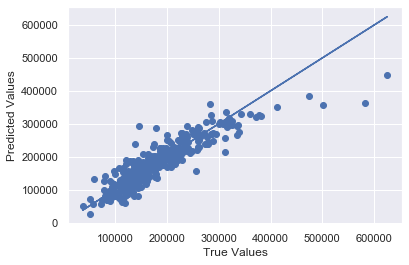

In [132]:
plt.scatter(y_test,y_pred)
plt.xlabel('True Values') #x label
plt.ylabel('Predicted Values') #y label

plt.plot(y_test,y_test)

<font size="3"> <b>  5. Final Model & Discussion </b></font>